In [8]:
import pandas as pd
import shutil
import os
import numpy as np
import seaborn as sns
!pip install resampy
!pip install librosa
import librosa
from librosa.effects import pitch_shift as librosa_pitch_shift
from librosa.effects import time_stretch as librosa_time_stretch

import resampy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils.class_weight import compute_class_weight

In [12]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Parametreler
input_shape = [256, 256, 1]  # Giriş şekli
num_classes = 10  # 10 sınıf
n_epochs = 100 # Eğitim epoch sayısı
batch_size = 64
learning_rate = 0.001  # Öğrenme oranı
fixed_sample_rate = 44100  # Sabit örnekleme hızı
n_mels = 64  # Mel-spektrogram için mel bandı sayısı
image_size = (256, 256)  # Görsel boyutu

# Verisetinin yolu
train_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train/"
train_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train.csv"

# CSV'yi oku
df_train = pd.read_csv(train_label_path)
df_train.head()

# Özellikler ve etiketler için boş listeler
feature = []
label = []

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def time_shift(y, shift_max=0.2):
    shift = np.random.randint(int(len(y) * shift_max))
    if np.random.rand() < 0.5:
        shift = -shift
    return np.roll(y, shift)

def pitch_shift_librosa(y, sr, n_steps=-6):
     # -max_steps..+max_steps arasında rasgele adım
     
    # kesinlikle alias’ı çağır
    return librosa_pitch_shift(y, sr=sr, n_steps=-6)

def time_stretch_librosa(y, max_rate_change=0.2):
      #1-max_rate_change .. 1+max_rate_change arasında rasgele hız
    rate = np.random.uniform(1-max_rate_change, 1+max_rate_change)
    return librosa_time_stretch(y, rate=2.0)


# Ses dosyalarını işleme
for i in tqdm(range(len(df_train))):
    file_name = train_data_path + df_train.iloc[i]["file_name"]
    y, sr = librosa.load(file_name, sr=fixed_sample_rate)

    # Rastgele augment uygulama (%50 şansla):
    if np.random.rand() < 0.5:
        y = add_noise(y, noise_factor=0.005)
    if np.random.rand() < 0.5:
        y = time_shift(y, shift_max=0.2)
    if np.random.rand() < 0.5:
        y = pitch_shift_librosa(y, sr=sr, n_steps=-6)

    if np.random.rand() < 0.5:
        y = time_stretch_librosa(y, max_rate_change=0.2)

    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=y, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)  # Logaritmik skala
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))  # 0-255 ölçekleme
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)  # Daha iyi interpolasyon
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)
    
    # Özellik ve etiket ekleme
    feature.append(mels_resized)
    label.append(df_train.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X = np.expand_dims(np.stack(feature, axis=0), axis=3)  # Kanal boyutu ekleme
Y = np.array(label)
Y = to_categorical(Y)  # Etiketleri one-hot encode

# Veri setini bölme
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=1)

# Model adı ve parametreler
model_name = "kerim"

# Sınıf ağırlıklarını hesapla
classes = np.unique(Y_train.argmax(axis=1))  # Y_train argmax ile sınıf etiketlerini elde et
class_weights = compute_class_weight('balanced', classes=classes, y=Y_train.argmax(axis=1))  # Ağırlıkları hesapla
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}  # Ağırlıkları sözlük formatında düzenle


# Model oluştur ve derle
model = create_model(input_shape, num_classes)
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbackler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_cb = ModelCheckpoint(filepath=model_name + '_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=os.path.join("logs", model_name), histogram_freq=1)

callbacks = [lr_scheduler, early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# Model eğitimi
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=n_epochs,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    verbose=1
)

# Modeli kaydet
model.save(model_name + '.keras')
print(f"Model {model_name}.keras olarak kaydedildi.")

 12%|█▏        | 831/7057 [01:22<07:59, 12.99it/s] /usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1102
  warnings.warn(
 12%|█▏        | 835/7057 [01:23<05:50, 17.77it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1522
  warnings.warn(
100%|██████████| 7057/7057 [09:49<00:00, 11.97it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1136 - loss: 3.4827
Epoch 1: val_loss improved from inf to 2.30248, saving model to kerim_best.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.1134 - loss: 3.4753 - val_accuracy: 0.0517 - val_loss: 2.3025 - learning_rate: 0.0010
Epoch 2/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1020 - loss: 2.3544
Epoch 2: val_loss improved from 2.30248 to 2.29946, saving model to kerim_best.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.1018 - loss: 2.3537 - val_accuracy: 0.0517 - val_loss: 2.2995 - learning_rate: 0.0010
Epoch 3/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1171 - loss: 2.2323
Epoch 3: val_loss did not improve from 2.29946
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.1173 - loss: 2.2321 - val_accuracy: 0.0425 - val_loss: 7.0765 - learning_rate: 0.0010
Epoch 4/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1469 - loss: 2.1917
Epoch 4: val_loss di

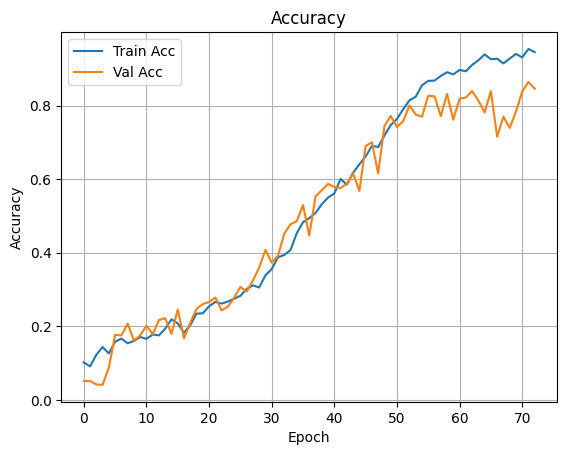

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy')
plt.show()


In [14]:
!pip install gdown
import gdown

# Test veri yolu ve etiketleri
test_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public/"
test_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public.csv"
df_test = pd.read_csv(test_label_path)

feature_test = []
label_test = []

for i in tqdm(range(len(df_test))):
    file_name = test_data_path + df_test.iloc[i]["file_name"]
    
    # Ses dosyasını yükle ve yeniden örnekle
    X, sr = librosa.load(file_name, sr=fixed_sample_rate)
    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=X, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)  # Logaritmik skala
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))  # 0-255 ölçekleme
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)  # Daha iyi interpolasyon
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)

    feature_test.append(mels_resized)
    label_test.append(df_test.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X_test = np.expand_dims(np.stack(feature_test, axis=0), axis=3)
Y_test = np.array(label_test)
Y_test = to_categorical(Y_test)

# Modeli yükleme
url = "https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z"
output = 'kerim.keras'
gdown.download(url, output, quiet=False)

model = tf.keras.models.load_model(output)

# Test verisi ile tahmin yapma
predictions = model.predict(X_test)

# Test seti değerlendirme
score_test = model.evaluate(X_test, Y_test)

print(f"Test Loss: {score_test[0]}")
print(f"Test Accuracy: {score_test[1]}")

100%|██████████| 82/82 [00:03<00:00, 24.01it/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z
From (redirected): https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z&confirm=t&uuid=a7dc766d-a5a8-4f6b-bf3e-905214e04394
To: /kaggle/working/kerim.keras
100%|██████████| 69.3M/69.3M [00:01<00:00, 38.2MB/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.7318 - loss: 0.7081
Test Loss: 0.6293968558311462
Test Accuracy: 0.7682926654815674
